In [1]:
import os
import random
import shutil

In [2]:
!mkdir data # make a folder for data

In [3]:
# download and unzip augmented images (only containing augmented images)
!gdown "https://drive.google.com/uc?id=1ppu097m-uk8zo_dyHLpGfD25cx4Qs9qk"
!mv augmented_images_2.zip data/augmented_images_2.zip
!unzip -qq data/augmented_images_2.zip -d data/

Downloading...
From (original): https://drive.google.com/uc?id=1ppu097m-uk8zo_dyHLpGfD25cx4Qs9qk
From (redirected): https://drive.google.com/uc?id=1ppu097m-uk8zo_dyHLpGfD25cx4Qs9qk&confirm=t&uuid=d65645c8-aa6a-42cd-8d0d-1ee99f69a5c3
To: /content/augmented_images_2.zip
100% 4.48G/4.48G [00:55<00:00, 80.2MB/s]


In [9]:
# download and unzip balanced images (only containing original images)
!gdown "https://drive.google.com/uc?id=1KSuRlc6vwBdqu47YTGZEzttf6XgUjIMC"
!mv cropped_images.zip data/cropped_images.zip
!unzip -qq data/cropped_images.zip -d data/

In [26]:
# download and unzip initial training and testing images (not balanced and not augmented)
!gdown "https://drive.google.com/uc?id=1vawS94rtmFBgxubs5uBIW-3RIB22Fnl1" -O initial_data.zip
!mv initial_data.zip data/initial_data.zip
!unzip -qq data/initial_data.zip -d data/

In [13]:
# from augmented images pick randomly some images for training and validating
!mkdir data/augmented_train/
!mkdir data/augmented_train/1
!mkdir data/augmented_train/10
!mkdir data/augmented_train/50
!mkdir data/augmented_train/100
!mkdir data/augmented_test/
!mkdir data/augmented_test/1
!mkdir data/augmented_test/10
!mkdir data/augmented_test/50
!mkdir data/augmented_test/100

data_path='data/'
source_path = data_path+'cropped_images/'
source_list=os.listdir(source_path)

source_augmented_path = data_path+'augmented_images_2/'

for class_idx in range(len(source_list)):

  class_path =  source_path+ str(source_list[class_idx])+'/'
  source_augmented_path = data_path+'augmented_images_2/'+str(source_list[class_idx])+'/'
  target_train_path = data_path+'augmented_train/'+str(source_list[class_idx])+'/'
  target_test_path = data_path+'augmented_test/'+str(source_list[class_idx])+'/'

  # 1200 per class
  file_list = os.listdir(class_path)

  random.shuffle(file_list)
  train_list = file_list[:-50]
  test_list = file_list[-50:]


  train_augmented_list=[]
  #get the augmented file name for training
  for image_name in train_list:
    for aug_idx in range(10):
      train_augmented_list.append(image_name+'_aug_'+str(aug_idx)+'.jpeg')



  for train_image in train_list:
    orig_image_path = class_path+train_image

    shutil.copy(orig_image_path, target_train_path+train_image )

    for aug_idx in range(10):
      augmented_file_name = train_image+'_aug_'+str(aug_idx)+'.jpeg'
      shutil.copy(source_augmented_path+augmented_file_name, target_train_path+augmented_file_name)
      #copy_list_this_turn.append(train_image+'_aug_'+str(aug_idx)+'.jpeg')

  for test_image in test_list:
    orig_image_path = class_path+test_image
    shutil.copy(orig_image_path, target_test_path+test_image)







In [14]:
# import required libraries
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D


In [ ]:
# check gpu
print(tf.sysconfig.get_build_info())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.experimental.list_logical_devices('GPU'))
#cuda.select_device(0)
#cuda.close()

In [27]:
# path to train data and test data
data_folder_path = "data/initial_train/"
test_folder_path = "data/initial_test/"

# path to train data and test data (augmented)
augmented_train_folder_path = "data/augmented_train/"
augmented_test_folder_path = "data/augmented_test/"


In [28]:
# train and test dataset
dimension = 299
batch_size=32
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_folder_path,
    image_size = (dimension,dimension),
    batch_size = batch_size,
    label_mode = 'categorical',
    shuffle=True

)

test_dataset =  tf.keras.preprocessing.image_dataset_from_directory(
    test_folder_path,
    image_size = (dimension,dimension),
    batch_size = batch_size,
    label_mode = 'categorical',
    shuffle=True

)



Found 5724 files belonging to 4 classes.
Found 633 files belonging to 4 classes.


In [33]:
# create model unless load existing model
def create_model():
  # Define the CNN model
  model = models.Sequential()

  # First convolutional layer
  model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256, 3), padding="same" )  )
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))

  # Second convolutional layer
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))

  # Third convolutional layer
  model.add(layers.Conv2D(128, (3, 3), activation='relu',padding="same"))
  model.add(layers.BatchNormalization())


  #model.add(layers.Conv2D(256, (3, 3), activation='relu', strides=2))
  model.add(layers.Conv2D(256, (3, 3), activation='relu', strides=1))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))

  model.add(layers.Conv2D(256, (3, 3), activation='relu', strides=1))
  model.add(layers.MaxPooling2D((2, 2)))


  model.add(layers.Conv2D(512, (3, 3), activation='relu', strides=1))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(512, (3, 3), activation='relu', strides=1))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.15))

  # Flatten the output and add fully connected layers
  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.3))
  model.add(layers.Dense(4, activation='softmax'))

  return model


In [21]:
# if using custom model
#model = create_model()


# if utilizing transfer learning

# load the inception V3 data without the top layer
model= tf.keras.applications.InceptionV3(include_top=False, input_shape=(299,299,3), weights= 'imagenet')

# modify the model and freeze layers

base_model=model

for layer in base_model.layers:
    layer.trainable = False

base_model.layers[-1]=True

num_classes=4
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add global average pooling layer
x = Dense(256, activation='relu')(x)  # Add a dense layer
predictions = Dense(num_classes, activation='softmax')(x)  # Final classification layer

# Define the new model
model = models.Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# train the data

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset, validation_data= test_dataset, epochs=130)

In [ ]:
# save the result

file_name= 'initial'
model99=model
history_used=history

# save the model
model99.save(f'{file_name}.keras')


In [ ]:
# get the result
train_history=[]
test_history=[]

for history_ in history_used:
  for epoch in range(len(history_.history['loss'])):
      train_history.append([history_.history['loss'][epoch],history_.history['accuracy'][epoch] ])
      test_history.append([history_.history['val_loss'][epoch],history_.history['val_accuracy'][epoch] ])


train_history = np.array(train_history)
test_history = np.array(test_history)

# save the acc and loss
# save the result
np.save(f'train_{file_name}.npy', train_history)
np.save(f'test_{file_name}.npy', test_history)

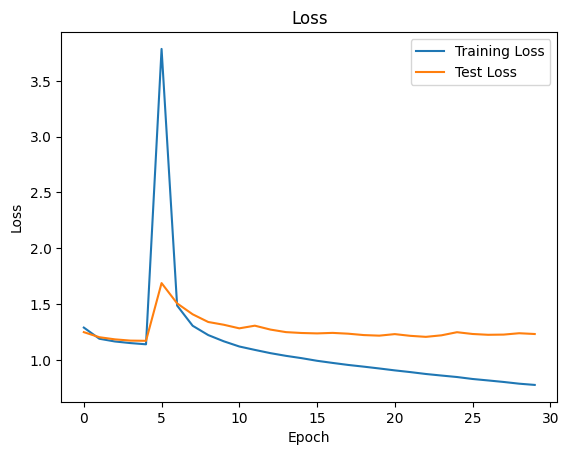

In [ ]:
# plot the results - loss
plt.plot(train_history[:,0])
plt.plot(test_history[:,0])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Val Loss'])
plt.show()

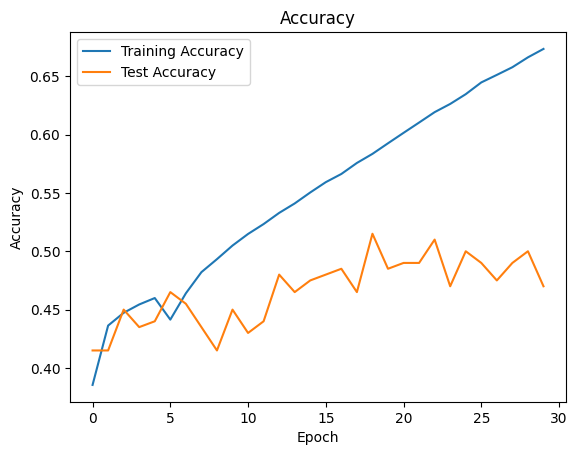

In [ ]:
# plot the results - accuracy
plt.plot(train_history[:,1])
plt.plot(test_history[:,1])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Val Accuracy'])
plt.show()